In [1]:
import cv2
import joblib
import pandas as pd 
import numpy as np
import albumentations as A
import tensorflow as tf
from time import time
from random import seed
from tensorflow import keras 
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from keras_cv.layers import DropBlock2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import Precision, BinaryAccuracy, Recall
from tensorflow.keras.regularizers import L2
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore') 
tf.config.run_functions_eagerly(True)

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [2]:
DATA_PATH = './data'
def load_dataset():
    X_yes = np.load(f'{DATA_PATH}/def_yes_images.npy')
    X_no = np.load(f'{DATA_PATH}/def_no_images.npy')
    classes = np.load(f'{DATA_PATH}/classes.npy')

    print(f'X_yes shape: {X_yes.shape}')
    print(f'X_no shape {X_no.shape}')
    print(f'classes shape: {classes.shape}')

    return X_yes, X_no, classes

def reshape_dataset(X_yes, X_no):
    X = np.row_stack((X_yes, X_no))
    N, SIZE_H, SIZE_V = X.shape
    X = np.reshape(X, newshape=(N, SIZE_H * SIZE_V))
    print(f'X shape: {X.shape}')
    return X

def data_augmentation(imgs, classes, aug_per_image, imgs_trans):
    new_images, new_classes = [], []
    for img, y, i in zip(imgs, classes, range(1, len(imgs) + 1)):
        for _ in range(aug_per_image):
            tmp_img = imgs_trans(image=img)["image"]
            new_images.append(tmp_img)
            new_classes.append(y)
        if i % 50 == 0: print(f'[!] {i} images agumented...')
    print(f'[!] Total of {len(imgs)} images augmented!\n')
    return new_images, new_classes

def sensitivity(y_true, y_pred):
    # tp/(fn + tp)
    y_true_tmp = y_true.numpy()
    y_pred_tmp = np.round(y_pred.numpy())
    tp = y_true_tmp[y_true_tmp == y_pred_tmp]
    tp = len(tp[tp == 1])
    fn = y_pred_tmp[y_true_tmp != y_pred_tmp]
    fn = len(fn[fn == 0])
    try:
        return tp / (tp + fn)
    except ZeroDivisionError:
        return 0.0

def specificity(y_true, y_pred):
    # tn / (fp + tn)
    y_true_tmp = y_true.numpy()
    y_pred_tmp = np.round(y_pred.numpy())
    tn = y_true_tmp[y_true_tmp == y_pred_tmp]
    tn = len(tn[tn == 0])
    fp = y_pred_tmp[y_true_tmp != y_pred_tmp]
    fp = len(fp[fp == 1])
    try:
        return tn / (tn + fp)
    except ZeroDivisionError:
        return 0.0

def balanced_accuracy(y_true, y_pred):
    # print(np.unique(y_true.numpy()))
    # print(np.unique(np.round(y_pred.numpy())))
    return balanced_accuracy_score(y_true.numpy(), np.round(y_pred.numpy()))

def balanced_acc(y_true, y_pred):
    return (sensitivity(y_true, y_pred) + specificity(y_true, y_pred)) / 2.0

def fit_evaluate(model, X_train, X_test, X_val, y_val, y_train, y_test, batch_size=32, epochs=100):
    res_model = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
    scores_model = model.evaluate(X_test, y_test)
    return res_model, scores_model

def graph_history(df, metrics, epochs=100):
    if len(metrics) == 1:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
        ax.plot(range(1, epochs+1), df[metrics[0]], 'b-', label='Train')
        ax.plot(range(1, epochs+1), df[f'val_{metrics[0]}'], 'r-', label='Validation')
        ax.set_title(metrics[0])
        ax.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(nrows=1, ncols=len(metrics), sharex=True, figsize=(30, 10))
        for i, metric in zip(range(len(metrics)), metrics):
            ax[i].plot(range(1, epochs+1), df[metric], 'b-', label='Train')
            ax[i].plot(range(1, epochs+1), df[f'val_{metric}'], 'r-', label='Validation')
            ax[i].set_title(metric)
            ax[i].legend()
        plt.show()

In [3]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
ss = StandardScaler()
X_tmp = np.reshape(X, newshape=(N, -1,))
X_tmp = ss.fit_transform(X_tmp)
X = np.reshape(X_tmp, newshape=(N, SIZE_H, SIZE_V))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [4]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True, stratify=classes)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True, stratify=y_train)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (123, 224, 224)
y_train shape (123,)
X_val shape: (31, 224, 224)
y_val shape (31,)
X_test shape: (66, 224, 224)
y_test shape: (66,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 120)               2

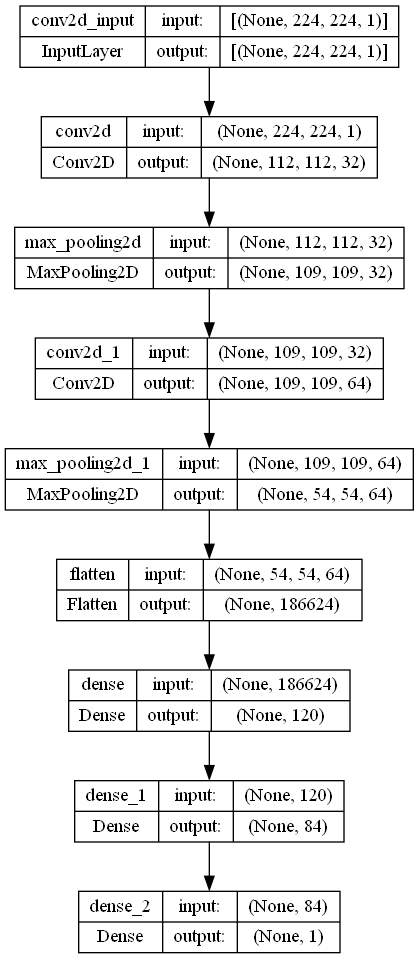

In [5]:
le_net_5 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding="same", input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    MaxPooling2D(pool_size=(4, 4), strides=1, padding="valid"),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
    # FLATTEN
    Flatten(),
    # DENSE LAYERS
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

IMG_PATH = './images'
print(le_net_5.summary())
plot_model(le_net_5, to_file=f'{IMG_PATH}/le_net_5.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      640       
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

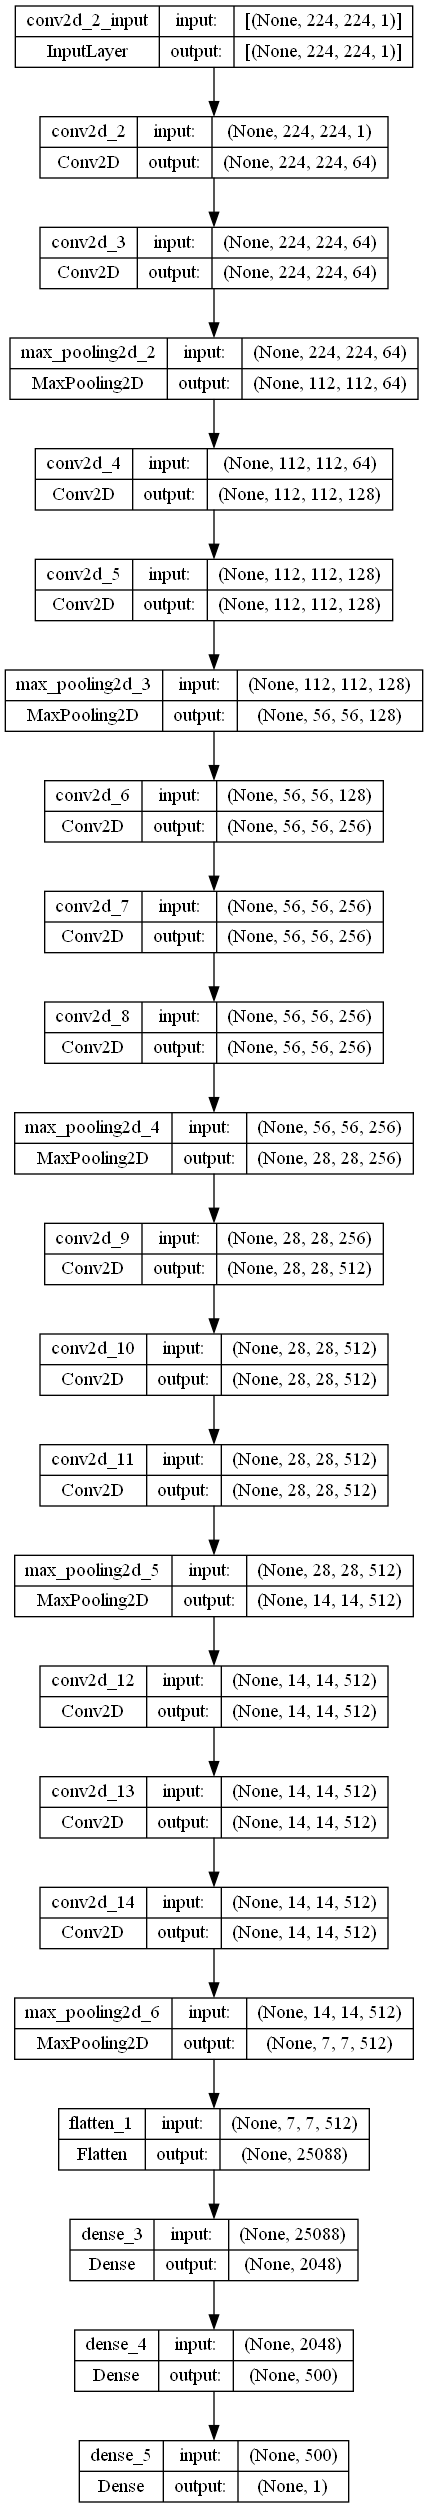

In [6]:
vgg_16 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 2
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 3
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 4
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 5
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # MAXPOOL BEFORE FC
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # FULLY CONNECTED LAYERS
    Flatten(),
    Dense(units=2048, activation='relu'),
    Dense(units=500, activation='relu'),
    # OUTPUT LAYER
    Dense(units=1, activation='sigmoid')
])

print(vgg_16.summary())
plot_model(vgg_16, to_file=f'{IMG_PATH}/vgg_16.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

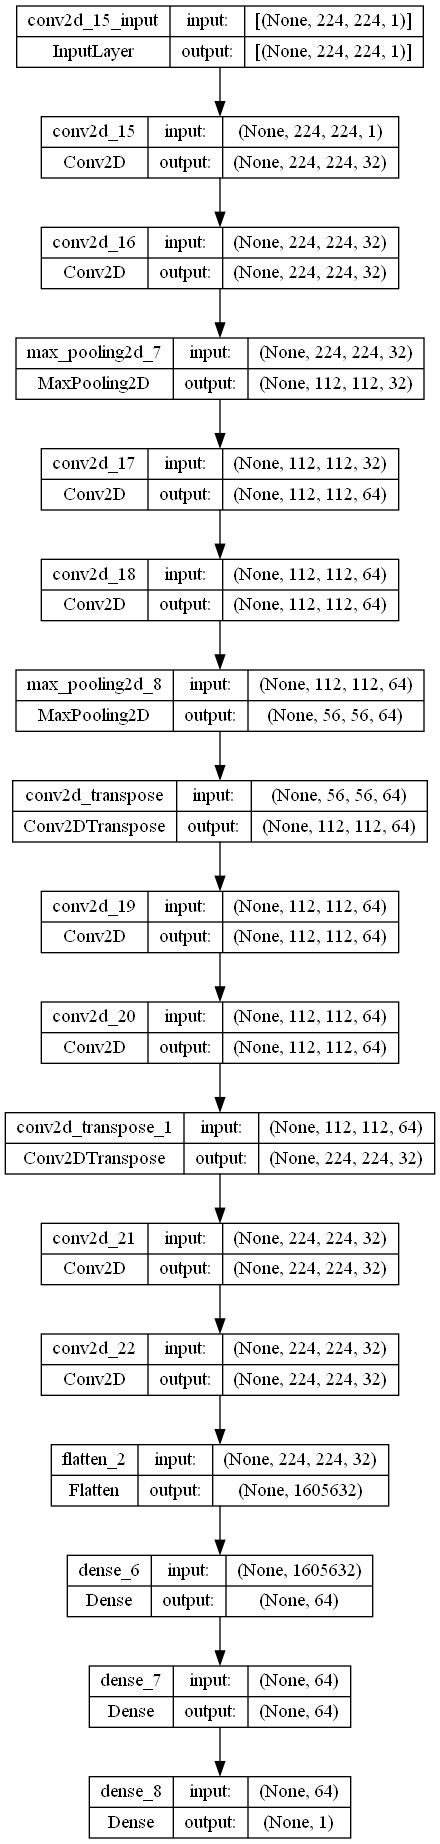

In [7]:
lu_net = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 3
    Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # LAYER 4
    Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # Fully connected layers
    Flatten(),
    Dense(units=64, activation='sigmoid'),
    Dense(units=64, activation='sigmoid'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

print(lu_net.summary())
plot_model(lu_net, to_file=f'{IMG_PATH}/lu_net.png', show_shapes=True, show_layer_names=True)

In [8]:
opt = keras.optimizers.Adam(learning_rate=1e-5)
METRICS = [
    Precision(),
    BinaryAccuracy(),
    Recall(),
    balanced_accuracy
]

le_net_5.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
vgg_16.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
lu_net.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

In [9]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 11s 2s/step - loss: 0.7264 - precision: 0.6265 - binary_accuracy: 0.5610 - recall: 0.6933 - balanced_accuracy: 0.5000 - val_loss: 0.6545 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 7s 2s/step - loss: 0.6474 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 0.6512 - val_precision: 0.6429 - val_binary_accuracy: 0.6452 - val_recall: 0.9474 - val_balanced_accuracy: 0.5570
Epoch 3/100
4/4 [==============================] - 6s 2s/step - loss: 0.6404 - precision: 0.7746 - binary_accuracy: 0.7073 - recall: 0.7333 - balanced_accuracy: 0.7331 - val_loss: 0.6419 - val_precision: 0.7000 - val_binary_accuracy: 0.6452 - val_recall: 0.7368 - val_balanced_accuracy: 0.6184
Epoch 4/100
4/4 [==============================] - 6s 2s/step - loss: 0.5887 - precision: 0.6952 - binary_accuracy: 0

In [10]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.726376,0.626506,0.560976,0.693333,0.500000,0.654482,0.612903,0.612903,1.000000,0.500000
1,0.647379,0.609756,0.609756,1.000000,0.500000,0.651163,0.642857,0.645161,0.947368,0.557018
2,0.640388,0.774648,0.707317,0.733333,0.733110,0.641912,0.700000,0.645161,0.736842,0.618421
3,0.588731,0.695238,0.723577,0.973333,0.636492,0.603464,0.612903,0.612903,1.000000,0.500000
4,0.563703,0.641026,0.658537,1.000000,0.572727,0.573768,0.678571,0.709677,1.000000,0.625000


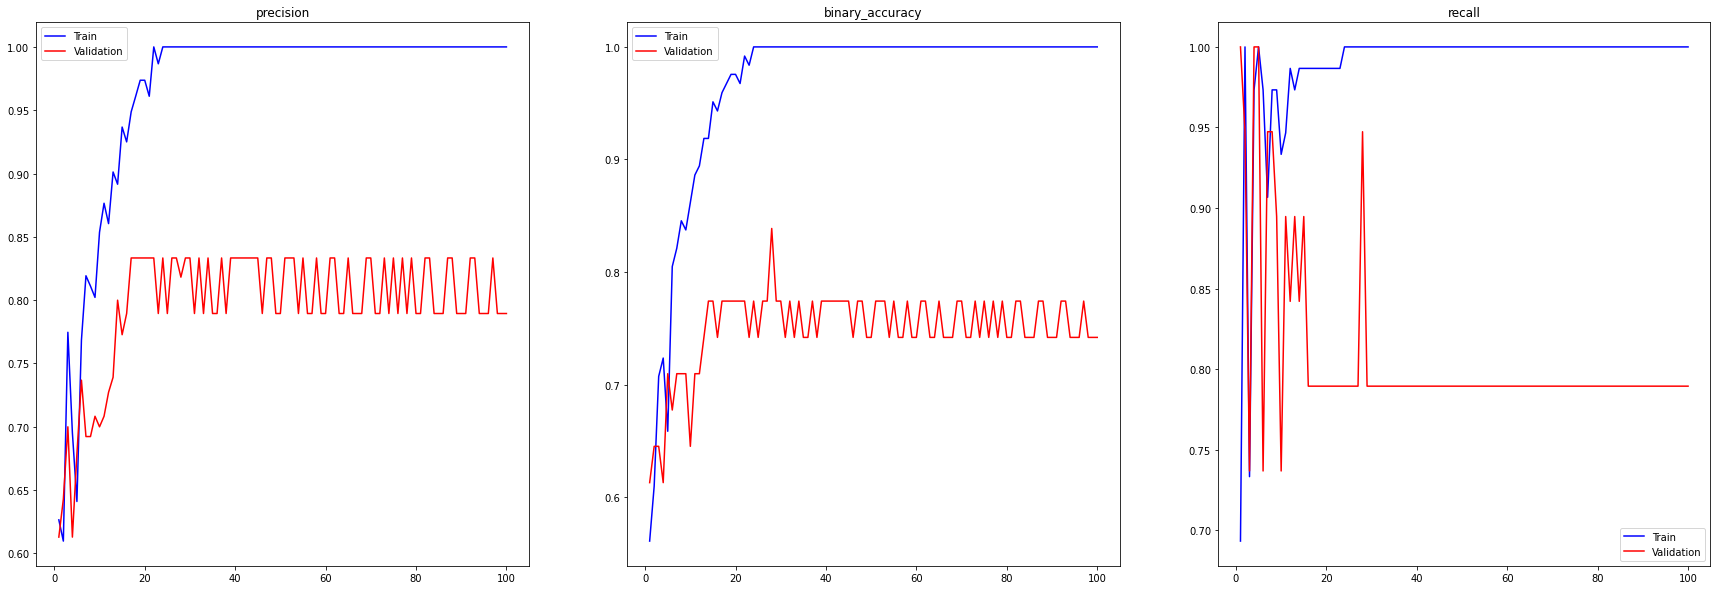

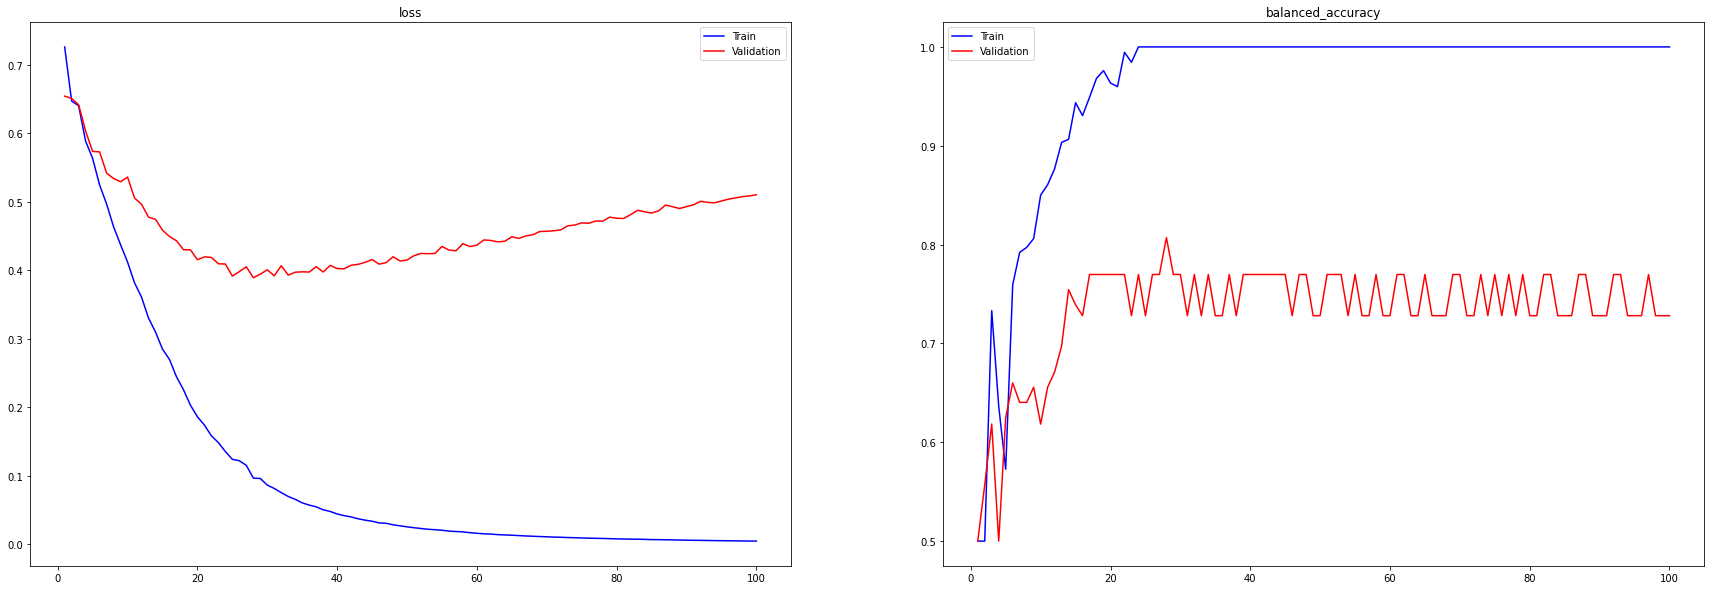

In [11]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['loss', 'balanced_accuracy']
graph_history(df_le_net_5, metrics_1)
graph_history(df_le_net_5, metrics_2)

In [12]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 74s 17s/step - loss: 0.6904 - precision: 0.6626 - binary_accuracy: 0.6720 - recall: 0.9391 - balanced_accuracy: 0.5000 - val_loss: 0.6709 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 66s 16s/step - loss: 0.6719 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 0.6437 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 69s 17s/step - loss: 0.6762 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 0.6390 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 64s 16s/step - loss: 0.6729 - precision: 0.6098 - binary_accu

In [13]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.690417,0.662577,0.671958,0.93913,0.5,0.670927,0.612903,0.612903,1.0,0.5
1,0.671881,0.609756,0.609756,1.00000,0.5,0.643674,0.612903,0.612903,1.0,0.5
2,0.676219,0.609756,0.609756,1.00000,0.5,0.639005,0.612903,0.612903,1.0,0.5
3,0.672886,0.609756,0.609756,1.00000,0.5,0.666360,0.612903,0.612903,1.0,0.5
4,0.666841,0.609756,0.609756,1.00000,0.5,0.651663,0.612903,0.612903,1.0,0.5


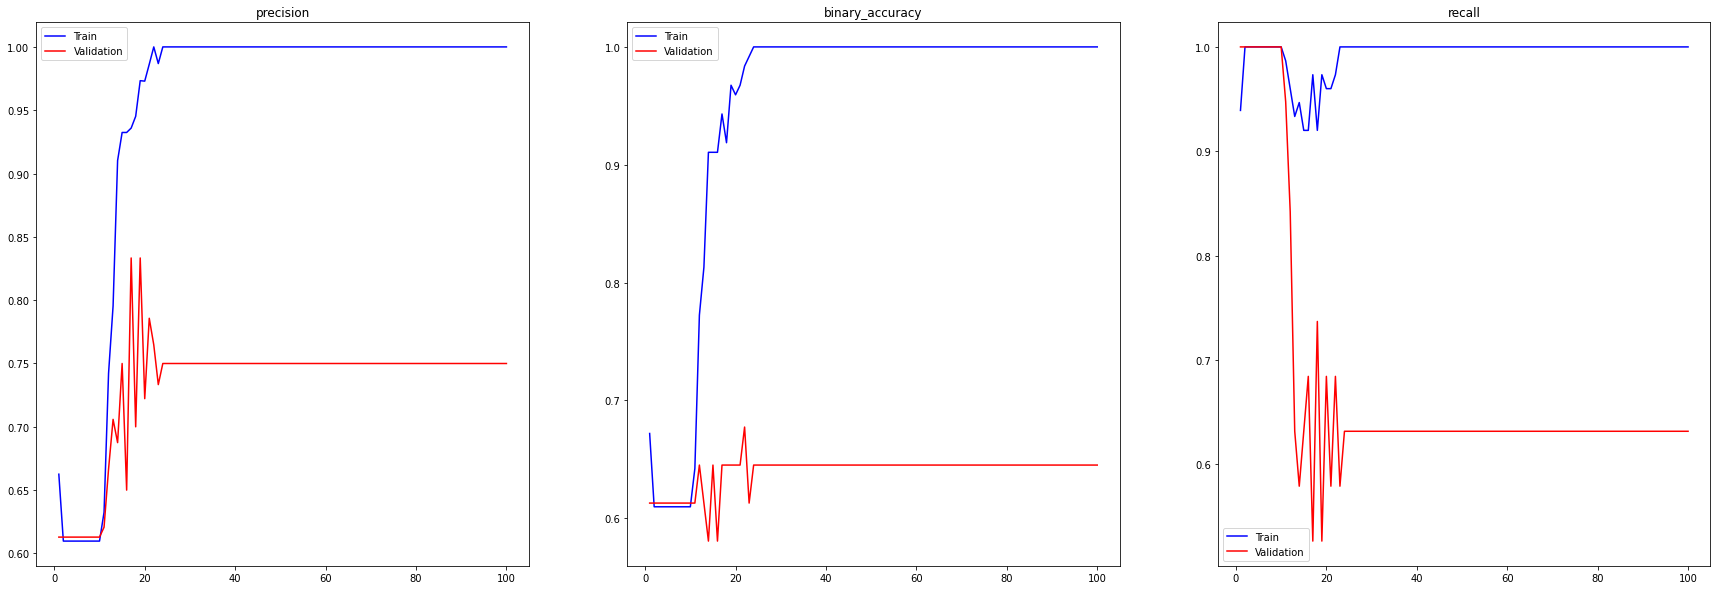

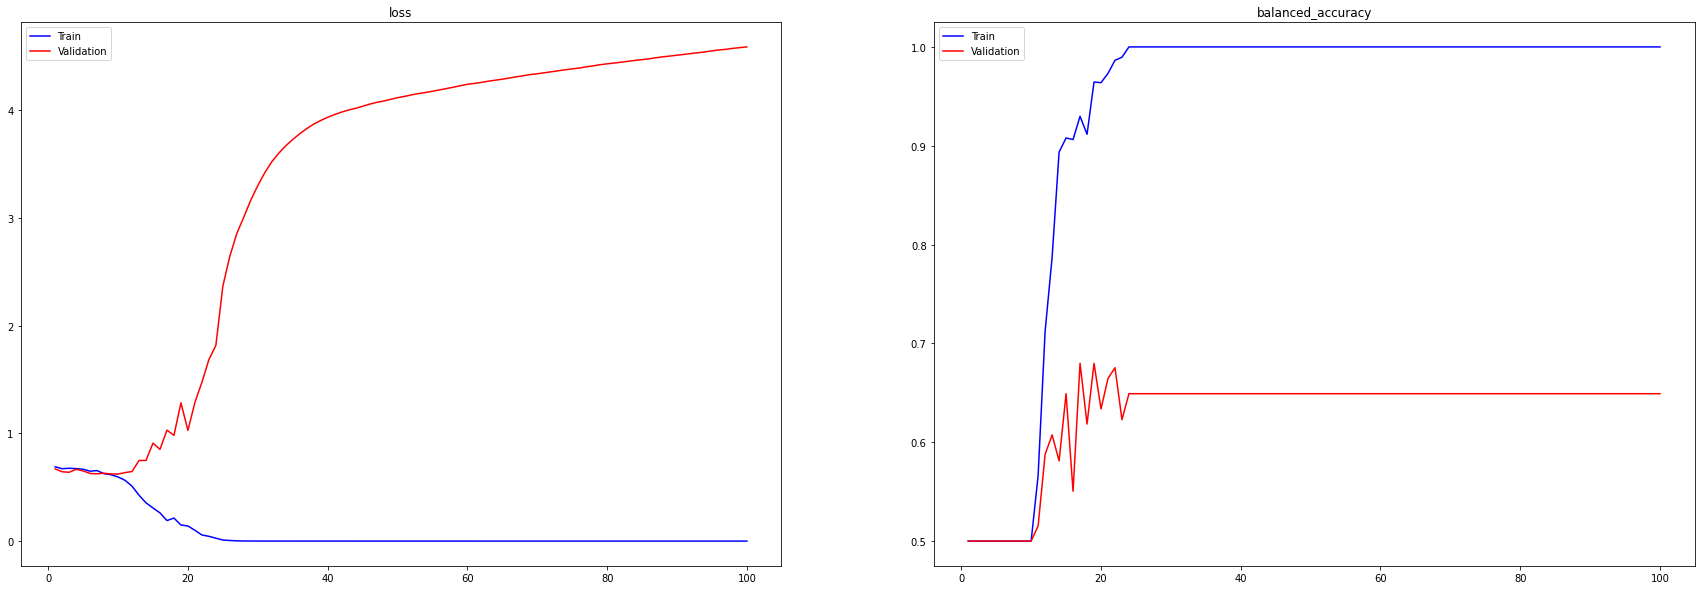

In [14]:
graph_history(df_vgg_16, metrics_1)
graph_history(df_vgg_16, metrics_2)

In [15]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 42s 10s/step - loss: 0.7512 - precision: 0.8293 - binary_accuracy: 0.5344 - recall: 0.2957 - balanced_accuracy: 0.5042 - val_loss: 0.6667 - val_precision: 0.6923 - val_binary_accuracy: 0.7097 - val_recall: 0.9474 - val_balanced_accuracy: 0.6404
Epoch 2/100
4/4 [==============================] - 33s 8s/step - loss: 0.6630 - precision: 0.6250 - binary_accuracy: 0.6179 - recall: 0.9333 - balanced_accuracy: 0.5303 - val_loss: 0.6495 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 33s 8s/step - loss: 0.6438 - precision: 0.6579 - binary_accuracy: 0.6829 - recall: 1.0000 - balanced_accuracy: 0.5897 - val_loss: 0.6196 - val_precision: 0.7391 - val_binary_accuracy: 0.7419 - val_recall: 0.8947 - val_balanced_accuracy: 0.6974
Epoch 4/100
4/4 [==============================] - 33s 8s/step - loss: 0.6279 - precision: 0.6701 - binary_accurac

In [16]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.751178,0.829268,0.534392,0.295652,0.504167,0.666680,0.692308,0.709677,0.947368,0.640351
1,0.663016,0.625000,0.617886,0.933333,0.530280,0.649527,0.612903,0.612903,1.000000,0.500000
2,0.643824,0.657895,0.682927,1.000000,0.589652,0.619604,0.739130,0.741935,0.894737,0.697368
3,0.627935,0.670103,0.658537,0.866667,0.602655,0.608169,0.727273,0.709677,0.842105,0.671053
4,0.606594,0.711111,0.699187,0.853333,0.660392,0.609143,0.692308,0.709677,0.947368,0.640351


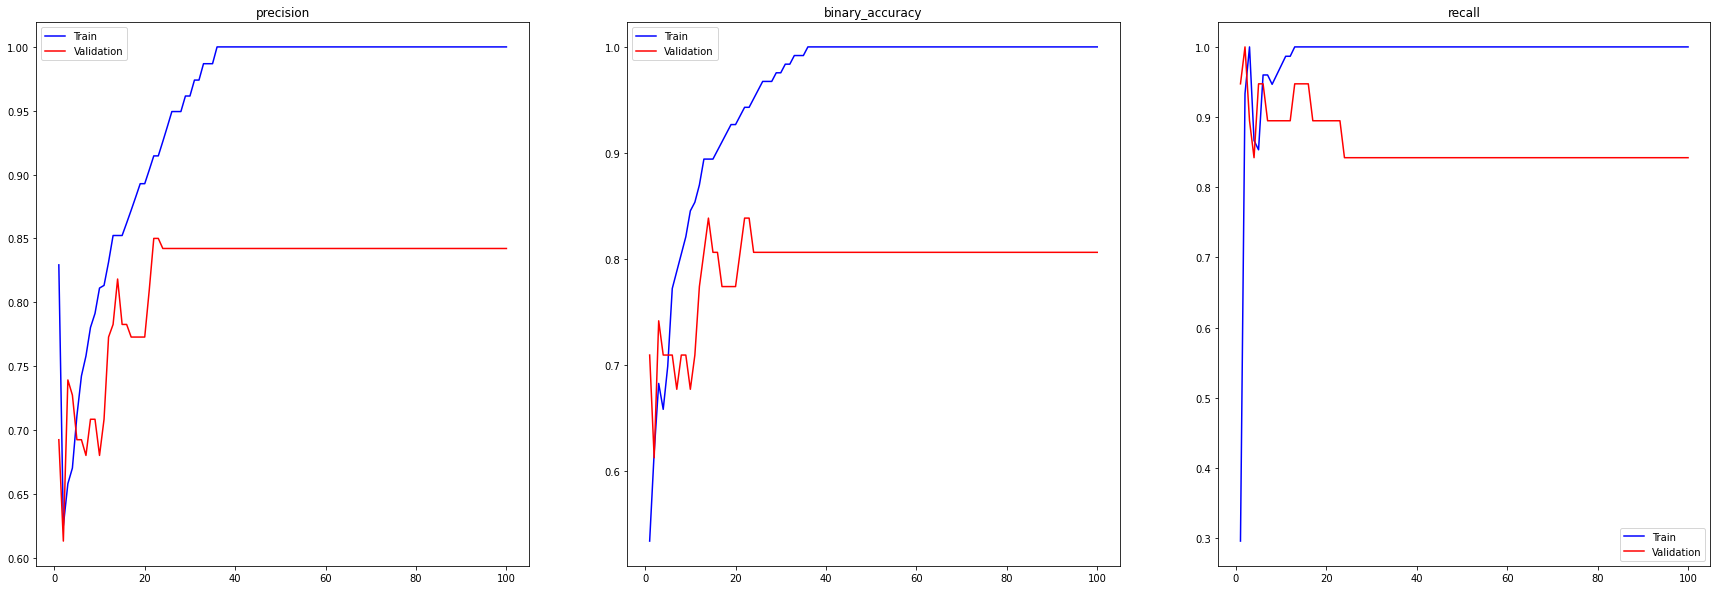

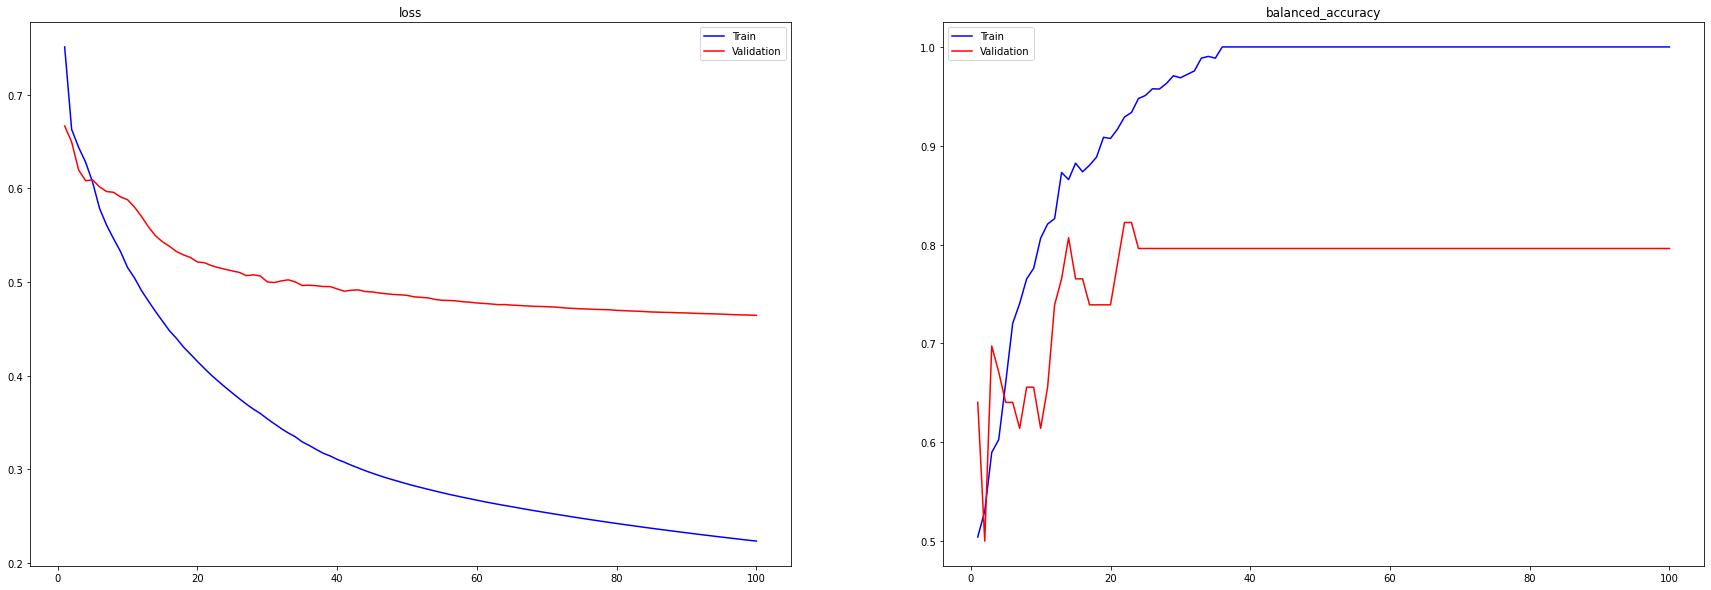

In [17]:
graph_history(df_lu_net, metrics_1)
graph_history(df_lu_net, metrics_2)

In [18]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

,Loss,Precision,Binary Accuracy,Recall,Balanced Accuracy
Le-Net 5,0.745477,0.825000,0.787879,0.825,0.850649
VGG-16,4.308762,0.861111,0.787879,0.775,0.859187
Lu-Net,0.595764,0.744186,0.712121,0.800,0.790524


In [19]:
RES_PATH = './results'
scores_df.to_csv(f'{RES_PATH}/test_scores_1.csv')
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_1.csv')
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_1.csv')
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_1.csv')

## DATA AUGMENTATION

In [3]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [4]:
imgs_trans = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=0.25),
    A.Rotate(limit=[-20, 20], p=0.25, border_mode=cv2.BORDER_CONSTANT),
    A.Affine(translate_percent=(-0.05, 0.05))
])

N_AUG = 20
n_yes = X_yes.shape[0]
X_yes, y_yes = data_augmentation(X_yes, classes[:n_yes], 13, imgs_trans)
X_yes, y_yes = np.array(X_yes), np.array(y_yes)
X_no, y_no = data_augmentation(X_no, classes[n_yes:], N_AUG, imgs_trans)
X_no, y_no = np.array(X_no), np.array(y_no)
print(f'X_yes shape: {X_yes.shape}')
print(f'X_no shape: {X_no.shape}')
X = np.row_stack((X_yes, X_no))
classes = np.concatenate((y_yes, y_no))
# X, y = data_augmentation(X, classes, N_AUG, imgs_trans)
# X, y = np.array(X), np.array(y)

ss = StandardScaler()
X_tmp = np.reshape(X, newshape=(X.shape[0], -1,))
X_tmp = ss.fit_transform(X_tmp)
X = np.reshape(X_tmp, newshape=(X.shape[0], SIZE_H, SIZE_V))
print(f'X shape: {X.shape}')
print(f'classes shape {classes.shape}')

[!] 50 images agumented...
[!] 100 images agumented...
[!] Total of 134 images augmented!

[!] 50 images agumented...
[!] Total of 86 images augmented!

X_yes shape: (1742, 224, 224)
X_no shape: (1720, 224, 224)
X shape: (3462, 224, 224)
classes shape (3462,)


In [5]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1938, 224, 224)
y_train shape (1938,)
X_val shape: (485, 224, 224)
y_val shape (485,)
X_test shape: (1039, 224, 224)
y_test shape: (1039,)


In [23]:
EPOCHS_2 = 60
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_2)

Epoch 1/60
61/61 [==============================] - 91s 1s/step - loss: 0.4850 - precision: 0.7819 - binary_accuracy: 0.7812 - recall: 0.7787 - balanced_accuracy: 0.7832 - val_loss: 0.3653 - val_precision: 0.8945 - val_binary_accuracy: 0.8619 - val_recall: 0.8159 - val_balanced_accuracy: 0.8683
Epoch 2/60
61/61 [==============================] - 88s 1s/step - loss: 0.3261 - precision: 0.8625 - binary_accuracy: 0.8602 - recall: 0.8563 - balanced_accuracy: 0.8578 - val_loss: 0.3676 - val_precision: 0.8113 - val_binary_accuracy: 0.8474 - val_recall: 0.8996 - val_balanced_accuracy: 0.8209
Epoch 3/60
61/61 [==============================] - 91s 2s/step - loss: 0.2860 - precision: 0.8845 - binary_accuracy: 0.8824 - recall: 0.8790 - balanced_accuracy: 0.8794 - val_loss: 0.3650 - val_precision: 0.9227 - val_binary_accuracy: 0.8454 - val_recall: 0.7490 - val_balanced_accuracy: 0.8379
Epoch 4/60
61/61 [==============================] - 92s 2s/step - loss: 0.2730 - precision: 0.8929 - binary_accu

In [24]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.485010,0.781931,0.781218,0.778697,0.783181,0.365333,0.894495,0.861856,0.815900,0.868277
1,0.326086,0.862500,0.860165,0.856256,0.857789,0.367613,0.811321,0.847423,0.899582,0.820913
2,0.285958,0.884495,0.882353,0.879007,0.879395,0.365004,0.922680,0.845361,0.748954,0.837926
3,0.273006,0.892931,0.891125,0.888314,0.891281,0.384863,0.759197,0.826804,0.949791,0.835908
4,0.231087,0.914761,0.912797,0.910031,0.914157,0.299489,0.922727,0.890722,0.849372,0.891825


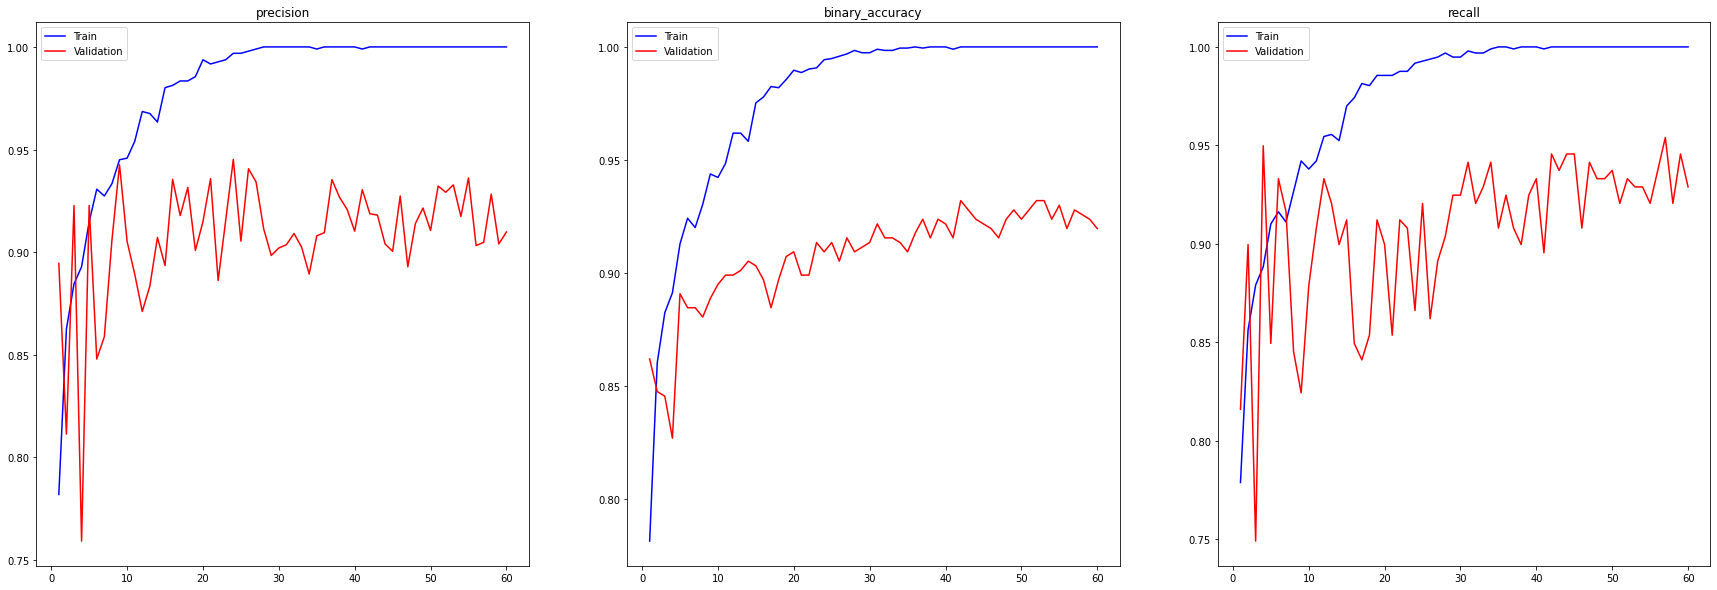

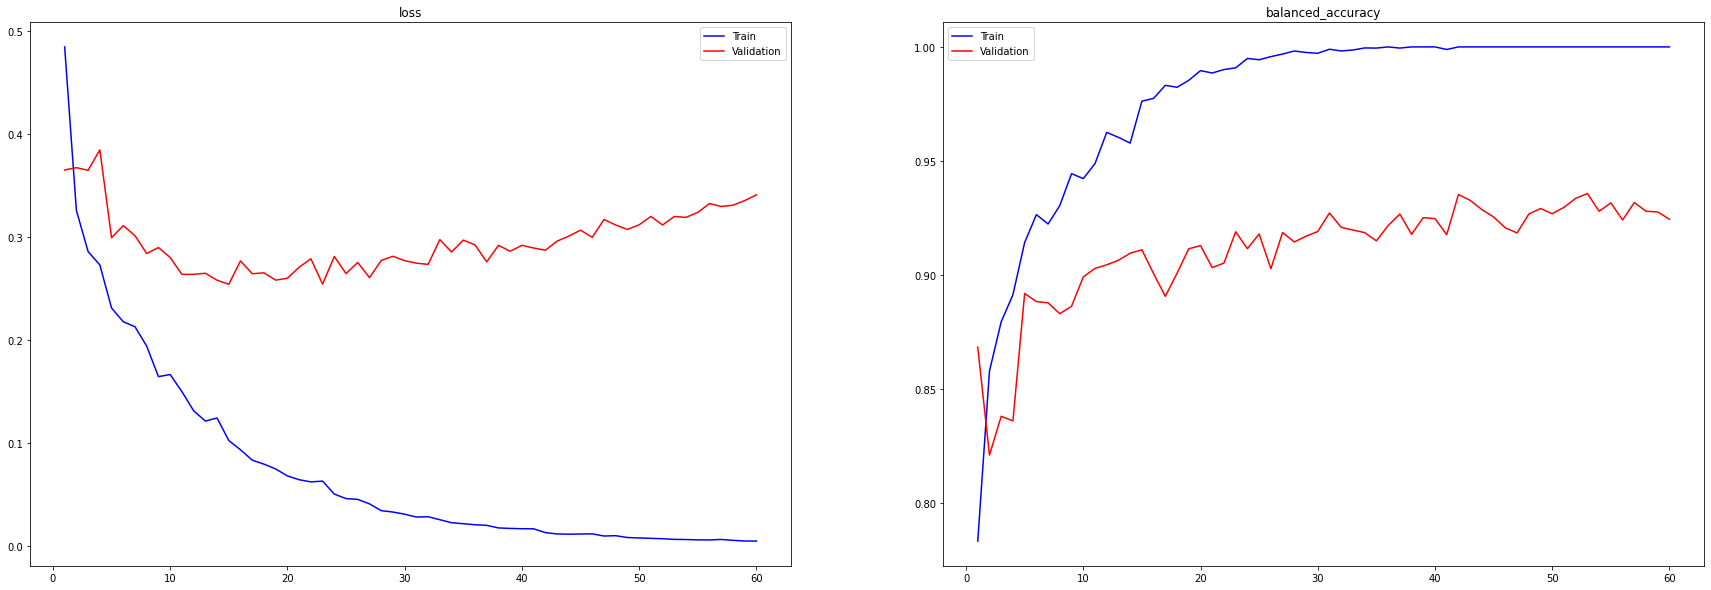

In [25]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['loss', 'balanced_accuracy']
graph_history(df_le_net_5, metrics_1, epochs=EPOCHS_2)
graph_history(df_le_net_5, metrics_2, epochs=EPOCHS_2)

In [26]:
RES_PATH = './results'
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_2.csv')

In [27]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_2)

Epoch 1/60
61/61 [==============================] - 949s 15s/step - loss: 0.8451 - precision: 0.5428 - binary_accuracy: 0.5666 - recall: 0.8335 - balanced_accuracy: 0.5755 - val_loss: 0.6539 - val_precision: 0.6471 - val_binary_accuracy: 0.7031 - val_recall: 0.8745 - val_balanced_accuracy: 0.7120
Epoch 2/60
61/61 [==============================] - 939s 15s/step - loss: 0.5663 - precision: 0.6868 - binary_accuracy: 0.7214 - recall: 0.8118 - balanced_accuracy: 0.7193 - val_loss: 0.4445 - val_precision: 0.7423 - val_binary_accuracy: 0.7979 - val_recall: 0.9038 - val_balanced_accuracy: 0.8041
Epoch 3/60
61/61 [==============================] - 933s 15s/step - loss: 0.4024 - precision: 0.8565 - binary_accuracy: 0.8292 - recall: 0.7901 - balanced_accuracy: 0.8279 - val_loss: 0.2927 - val_precision: 0.9182 - val_binary_accuracy: 0.8866 - val_recall: 0.8452 - val_balanced_accuracy: 0.8876
Epoch 4/60
61/61 [==============================] - 933s 15s/step - loss: 0.3101 - precision: 0.8983 - bin

In [28]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.845127,0.542761,0.566563,0.833506,0.575476,0.653914,0.647059,0.703093,0.874477,0.711980
1,0.566253,0.686789,0.721362,0.811789,0.719287,0.444547,0.742268,0.797938,0.903766,0.804142
2,0.402398,0.856502,0.829205,0.790072,0.827857,0.292749,0.918182,0.886598,0.845188,0.887604
3,0.310073,0.898268,0.880805,0.858325,0.880442,0.358991,0.988304,0.851546,0.707113,0.832611
4,0.237112,0.929501,0.909701,0.886246,0.910116,0.215184,0.917012,0.921649,0.924686,0.924332


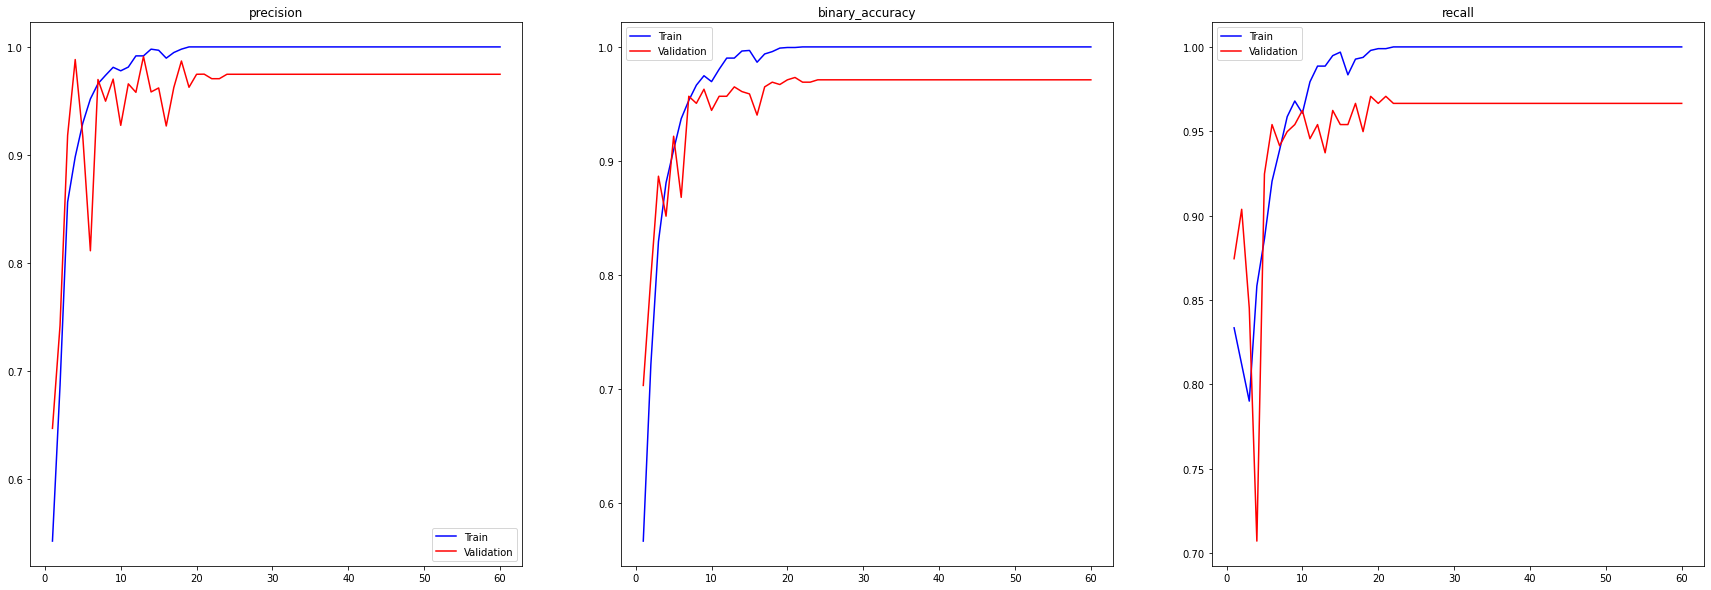

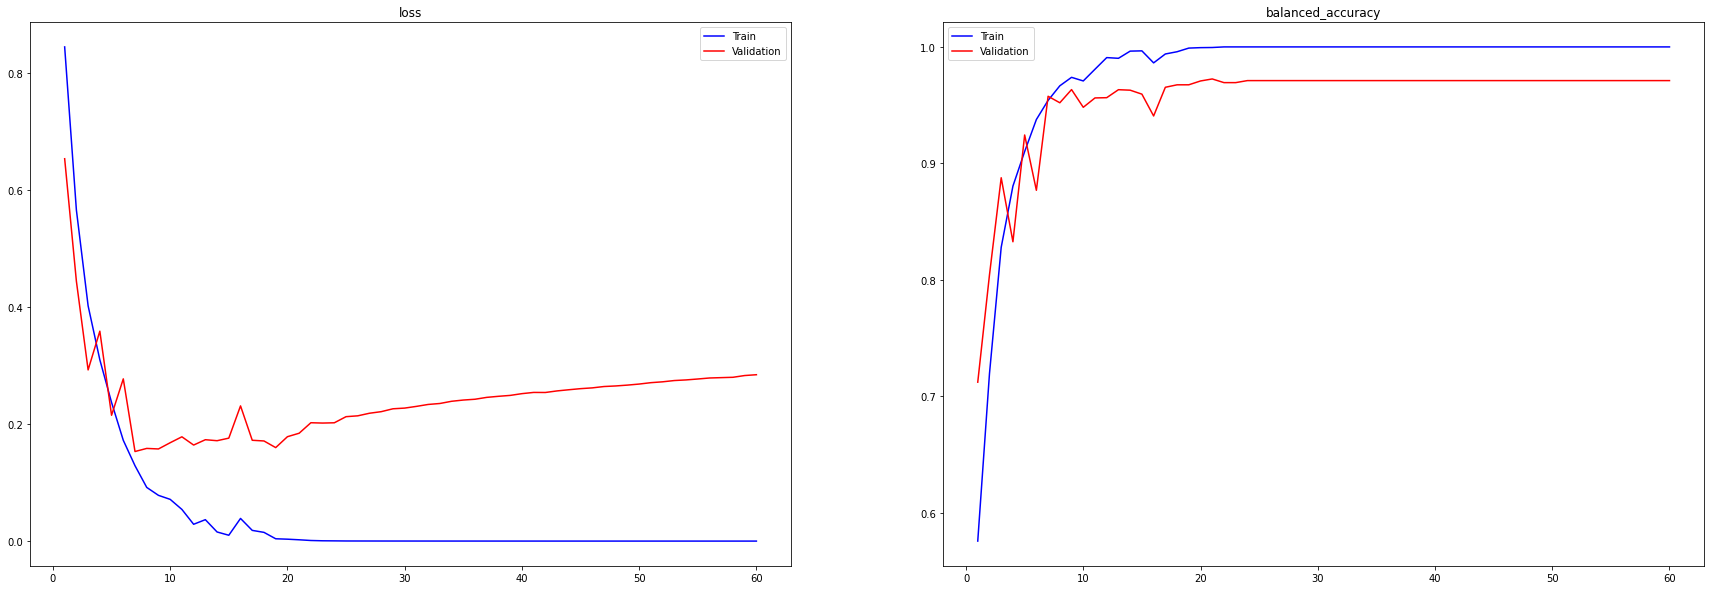

In [29]:
graph_history(df_vgg_16, metrics_1, epochs=EPOCHS_2)
graph_history(df_vgg_16, metrics_2, epochs=EPOCHS_2)

In [30]:
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_2.csv')

In [31]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_2)

Epoch 1/60
61/61 [==============================] - 531s 9s/step - loss: 0.5829 - precision: 0.6920 - binary_accuracy: 0.7069 - recall: 0.7435 - balanced_accuracy: 0.7055 - val_loss: 0.5064 - val_precision: 0.7472 - val_binary_accuracy: 0.7773 - val_recall: 0.8285 - val_balanced_accuracy: 0.7785
Epoch 2/60
61/61 [==============================] - 518s 8s/step - loss: 0.4849 - precision: 0.7878 - binary_accuracy: 0.7879 - recall: 0.7870 - balanced_accuracy: 0.7833 - val_loss: 0.4625 - val_precision: 0.7968 - val_binary_accuracy: 0.8144 - val_recall: 0.8368 - val_balanced_accuracy: 0.8111
Epoch 3/60
61/61 [==============================] - 515s 8s/step - loss: 0.4372 - precision: 0.8248 - binary_accuracy: 0.8282 - recall: 0.8325 - balanced_accuracy: 0.8282 - val_loss: 0.4366 - val_precision: 0.7962 - val_binary_accuracy: 0.8247 - val_recall: 0.8661 - val_balanced_accuracy: 0.8205
Epoch 4/60
61/61 [==============================] - 514s 8s/step - loss: 0.3919 - precision: 0.8683 - binary_

In [32]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.582894,0.692012,0.706914,0.743537,0.705512,0.506394,0.747170,0.777320,0.828452,0.778509
1,0.484896,0.787785,0.787926,0.786970,0.783341,0.462463,0.796813,0.814433,0.836820,0.811143
2,0.437200,0.824795,0.828173,0.832472,0.828241,0.436581,0.796154,0.824742,0.866109,0.820521
3,0.391882,0.868288,0.876161,0.886246,0.877119,0.420758,0.835443,0.835052,0.828452,0.832502
4,0.360247,0.901452,0.900413,0.898656,0.901081,0.400648,0.844538,0.845361,0.841004,0.840251


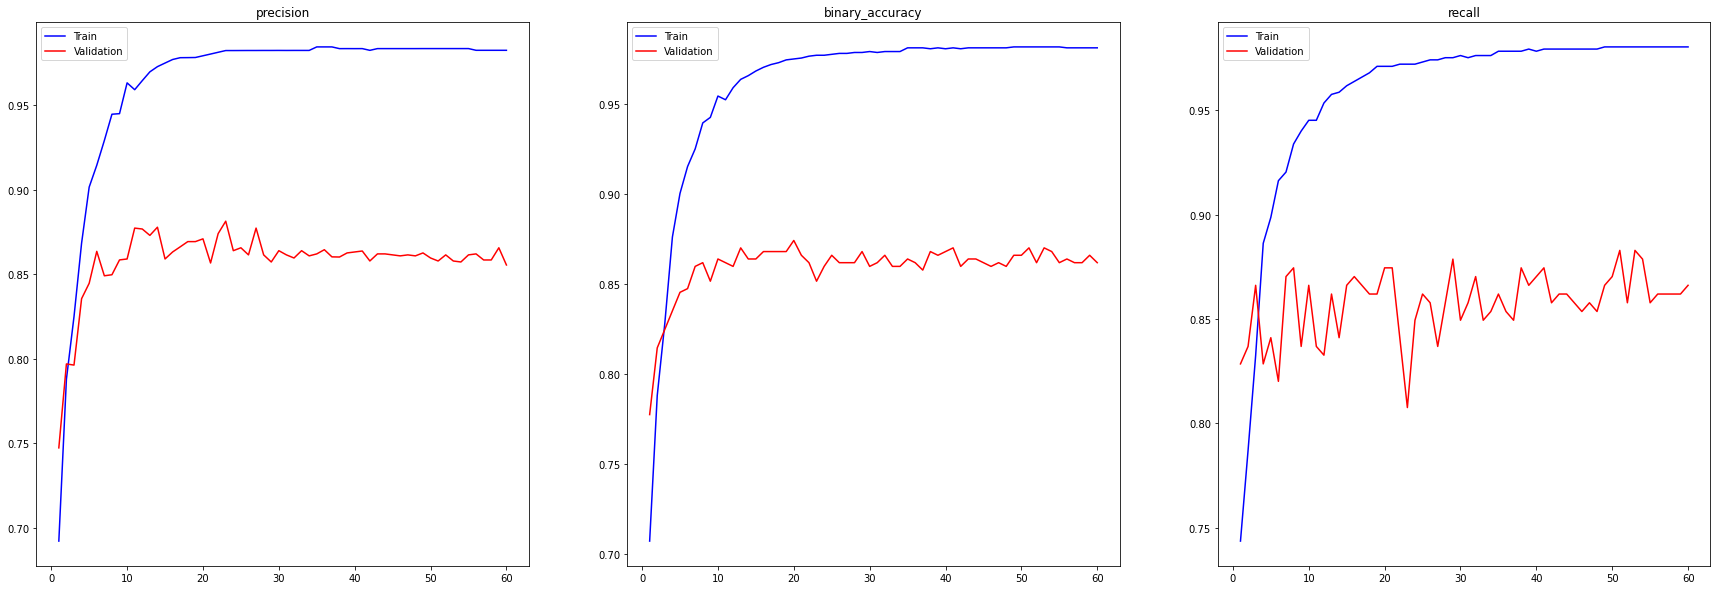

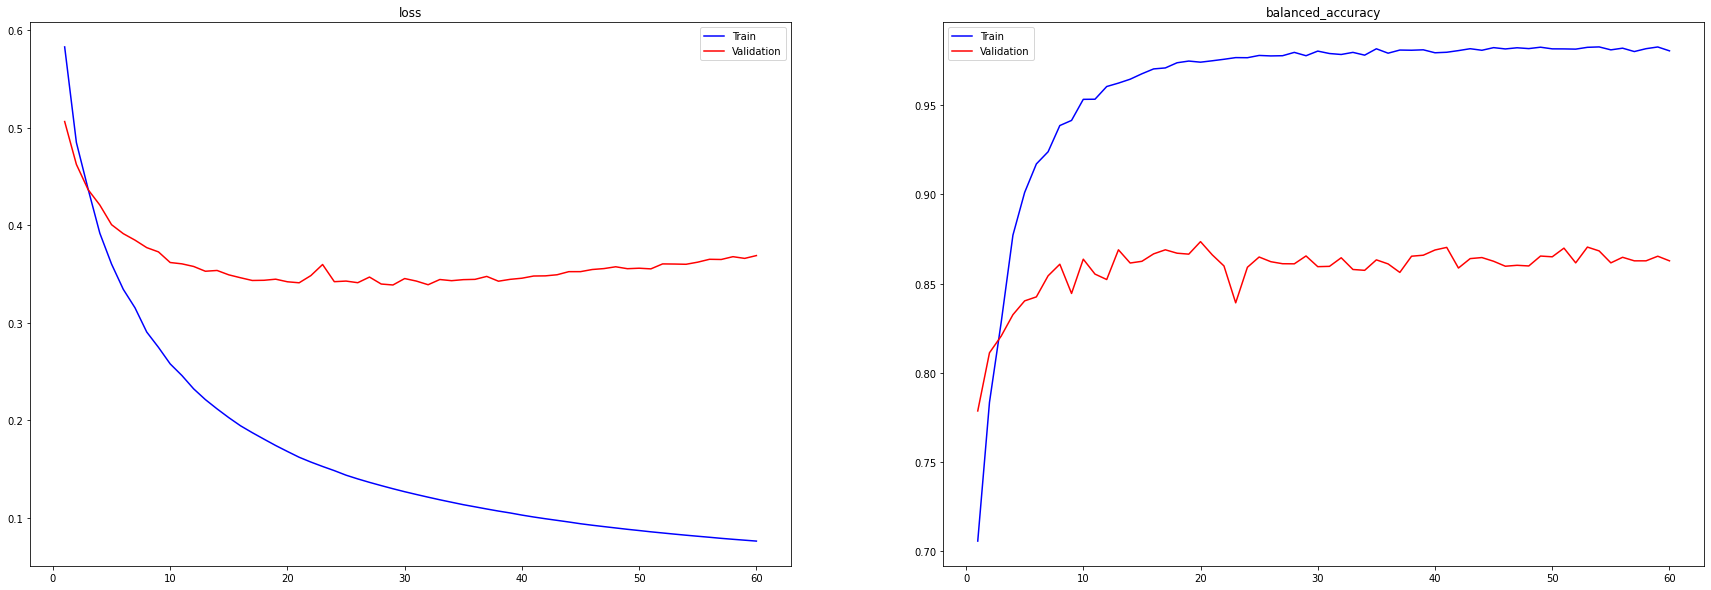

In [33]:
graph_history(df_lu_net, metrics_1, epochs=EPOCHS_2)
graph_history(df_lu_net, metrics_2, epochs=EPOCHS_2)

In [34]:
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_2.csv')

In [35]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

,Loss,Precision,Binary Accuracy,Recall,Balanced Accuracy
Le-Net 5,0.339432,0.895871,0.908566,0.930970,0.909673
VGG-16,0.266091,0.964552,0.963426,0.964552,0.962685
Lu-Net,0.411400,0.847706,0.848893,0.861940,0.847752


In [36]:
scores_df.to_csv(f'{RES_PATH}/test_scores_2.csv')

## CNNs with L-2 regularization and Dropout layers

In [3]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [4]:
imgs_trans = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=0.25),
    A.Rotate(limit=[-20, 20], p=0.25, border_mode=cv2.BORDER_CONSTANT),
    A.Affine(translate_percent=(-0.05, 0.05))
])

N_AUG = 20
n_yes = X_yes.shape[0]
X_yes, y_yes = data_augmentation(X_yes, classes[:n_yes], 13, imgs_trans)
X_yes, y_yes = np.array(X_yes), np.array(y_yes)
X_no, y_no = data_augmentation(X_no, classes[n_yes:], N_AUG, imgs_trans)
X_no, y_no = np.array(X_no), np.array(y_no)
print(f'X_yes shape: {X_yes.shape}')
print(f'X_no shape: {X_no.shape}')
X = np.row_stack((X_yes, X_no))
classes = np.concatenate((y_yes, y_no))
# X, y = data_augmentation(X, classes, N_AUG, imgs_trans)
# X, y = np.array(X), np.array(y)

ss = StandardScaler()
X_tmp = np.reshape(X, newshape=(X.shape[0], -1,))
X_tmp = ss.fit_transform(X_tmp)
X = np.reshape(X_tmp, newshape=(X.shape[0], SIZE_H, SIZE_V))
print(f'X shape: {X.shape}')
print(f'classes shape {classes.shape}')

[!] 50 images agumented...
[!] 100 images agumented...
[!] Total of 134 images augmented!

[!] 50 images agumented...
[!] Total of 86 images augmented!

X_yes shape: (1742, 224, 224)
X_no shape: (1720, 224, 224)
X shape: (3462, 224, 224)
classes shape (3462,)


In [5]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1938, 224, 224)
y_train shape (1938,)
X_val shape: (485, 224, 224)
y_val shape (485,)
X_test shape: (1039, 224, 224)
y_test shape: (1039,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      832       
                                                                 
 drop_block2d (DropBlock2D)  (None, 112, 112, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      51264     
                                                                 
 drop_block2d_1 (DropBlock2D  (None, 109, 109, 64)     0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0

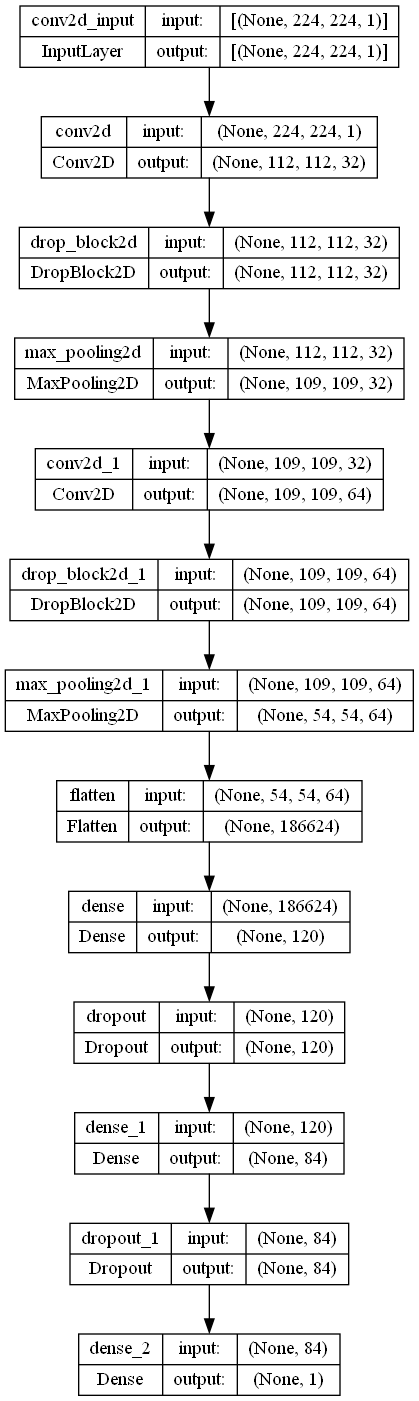

In [6]:
DROPOUT_RATE = 0.4
DROPBLOCK_RATE = 0.1
le_net_5 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding="same", input_shape=(SIZE_H, SIZE_V, 1), activation='relu', kernel_regularizer=L2(0.1)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    MaxPooling2D(pool_size=(4, 4), strides=1, padding="valid"),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding="same", activation='relu', kernel_regularizer=L2(0.1)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
    # FLATTEN
    Flatten(),
    # DENSE LAYERS
    Dense(units=120, activation='relu'),
    Dropout(DROPOUT_RATE, seed=sd),
    Dense(units=84, activation='relu'),
    Dropout(DROPOUT_RATE, seed=sd),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

IMG_PATH = './images'
print(le_net_5.summary())
plot_model(le_net_5, to_file=f'{IMG_PATH}/le_net_5_dropout.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      640       
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 drop_block2d_2 (DropBlock2D  (None, 224, 224, 64)     0         
 )                                                               
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)    

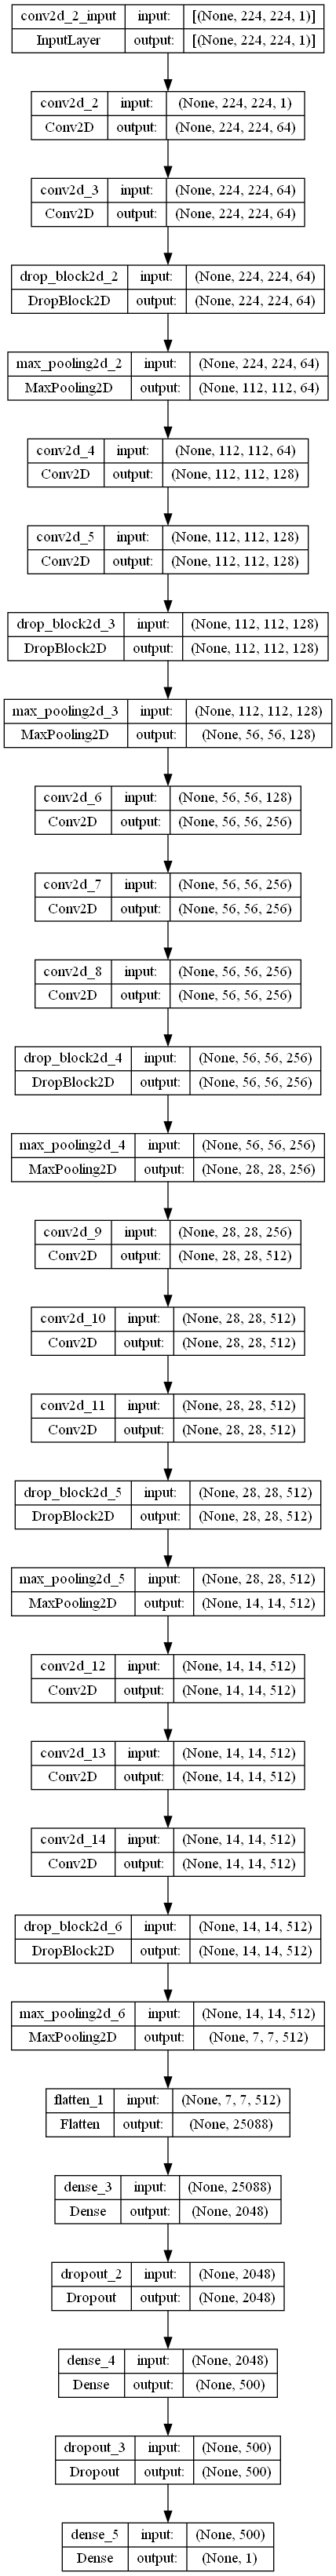

In [7]:
DROPOUT_RATE = 0.3
DROPBLOCK_RATE = 0.05
vgg_16 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    # LAYER 2
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    # LAYER 3
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    # LAYER 4
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    # LAYER 5
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    # MAXPOOL BEFORE FC
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # FULLY CONNECTED LAYERS
    Flatten(),
    Dense(units=2048, activation='relu'),
    Dropout(DROPOUT_RATE, seed=sd),
    Dense(units=500, activation='relu'),
    Dropout(DROPOUT_RATE, seed=sd),
    # OUTPUT LAYER
    Dense(units=1, activation='sigmoid')
])

print(vgg_16.summary())
plot_model(vgg_16, to_file=f'{IMG_PATH}/vgg_16_dropout.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 drop_block2d_7 (DropBlock2D  (None, 224, 224, 32)     0         
 )                                                               
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 drop_block2d_8 (DropBlock2D  (None, 112, 112, 64)    

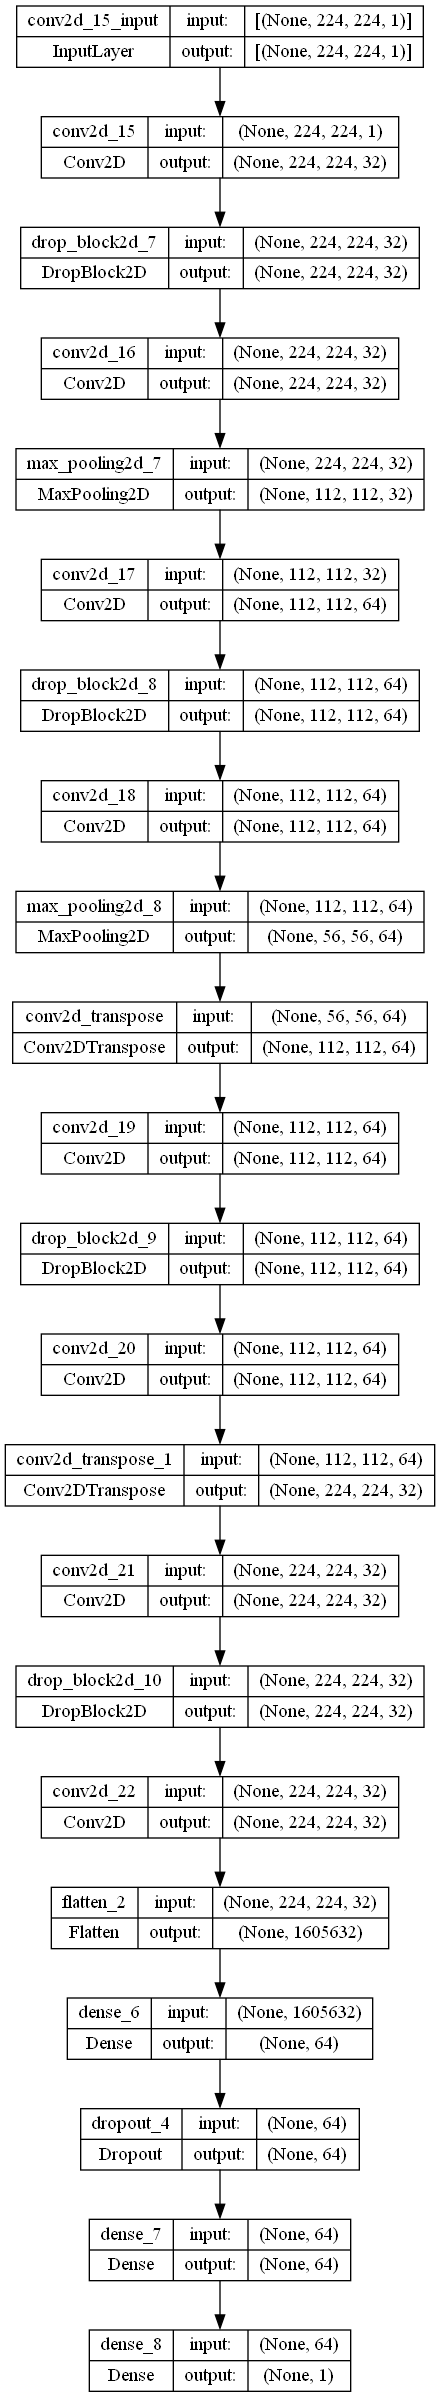

In [8]:
DROPOUT_RATE = 0.3
DROPBLOCK_RATE = 0.05
L2_VALUE = 0.001
lu_net = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='elu'),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 3
    Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # LAYER 4
    Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # Fully connected layers
    Flatten(),
    Dense(units=64, activation='sigmoid'),
    Dropout(DROPOUT_RATE, seed=sd),
    Dense(units=64, activation='sigmoid'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

print(lu_net.summary())
plot_model(lu_net, to_file=f'{IMG_PATH}/lu_net_dropout.png', show_shapes=True, show_layer_names=True)

In [9]:
EPOCHS_3 = 60
RES_PATH = './results'
opt = keras.optimizers.Adam(learning_rate=1e-5)
METRICS = [
    Precision(),
    BinaryAccuracy(),
    Recall(),
    balanced_accuracy
]

le_net_5.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
vgg_16.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
lu_net.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

In [44]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_3)

Epoch 1/60
61/61 [==============================] - 139s 2s/step - loss: 3.5820 - precision_1: 0.5636 - binary_accuracy: 0.5764 - recall_1: 0.6691 - balanced_accuracy: 0.5701 - val_loss: 2.0095 - val_precision_1: 0.7905 - val_binary_accuracy: 0.6845 - val_recall_1: 0.4895 - val_balanced_accuracy: 0.6849
Epoch 2/60
61/61 [==============================] - 130s 2s/step - loss: 1.4145 - precision_1: 0.7348 - binary_accuracy: 0.6966 - recall_1: 0.6132 - balanced_accuracy: 0.6948 - val_loss: 1.0278 - val_precision_1: 0.8119 - val_binary_accuracy: 0.7670 - val_recall_1: 0.6862 - val_balanced_accuracy: 0.7589
Epoch 3/60
61/61 [==============================] - 132s 2s/step - loss: 0.7323 - precision_1: 0.8385 - binary_accuracy: 0.8256 - recall_1: 0.8056 - balanced_accuracy: 0.8275 - val_loss: 0.5962 - val_precision_1: 0.8240 - val_binary_accuracy: 0.8412 - val_recall_1: 0.8619 - val_balanced_accuracy: 0.8345
Epoch 4/60
61/61 [==============================] - 135s 2s/step - loss: 0.4671 - pre

In [45]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision_1,binary_accuracy,recall_1,balanced_accuracy,val_loss,val_precision_1,val_binary_accuracy,val_recall_1,val_balanced_accuracy
0,3.582030,0.563589,0.576367,0.669080,0.570136,2.009532,0.790541,0.684536,0.489540,0.684923
1,1.414524,0.734820,0.696594,0.613237,0.694850,1.027837,0.811881,0.767010,0.686192,0.758937
2,0.732350,0.838536,0.825593,0.805584,0.827517,0.596215,0.824000,0.841237,0.861925,0.834531
3,0.467060,0.889124,0.881321,0.870734,0.878995,0.444132,0.814126,0.855670,0.916318,0.828539
4,0.356721,0.905208,0.902477,0.898656,0.902948,0.353664,0.892116,0.896907,0.899582,0.898672


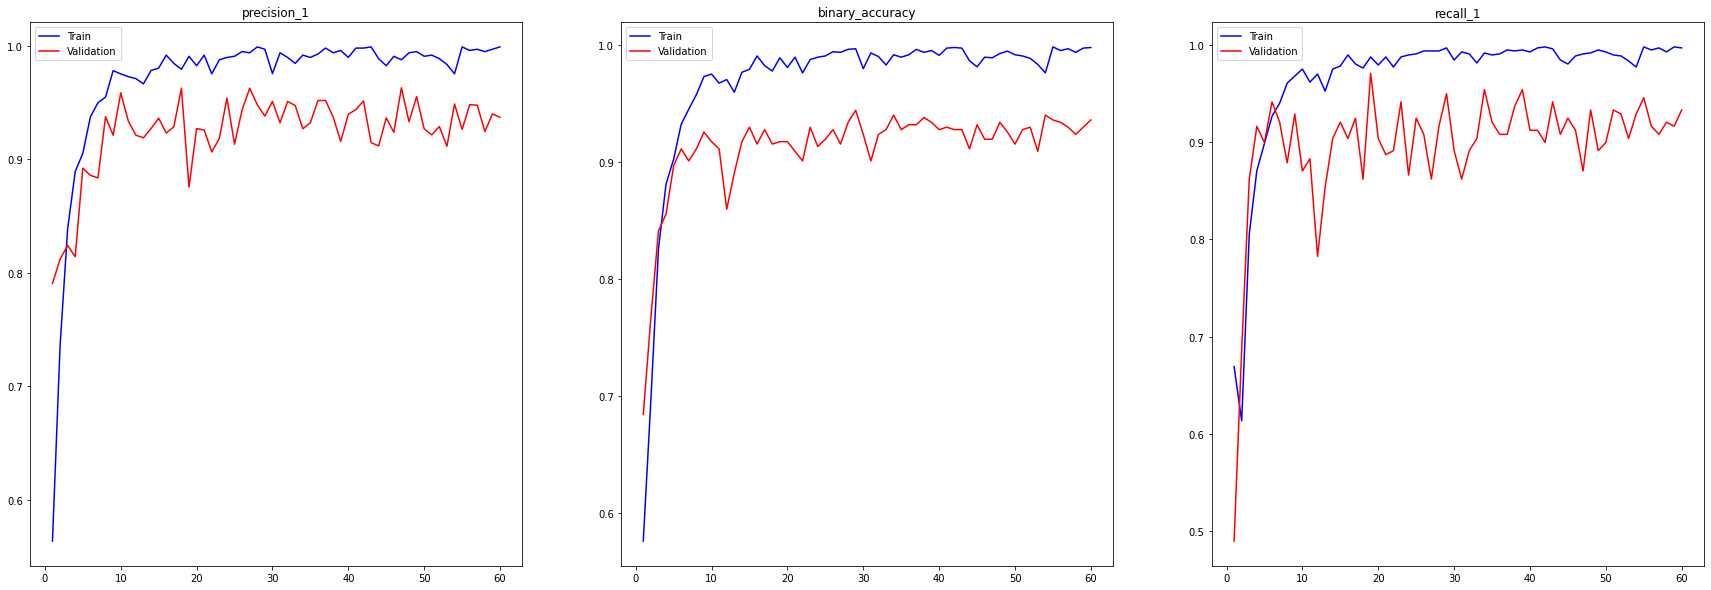

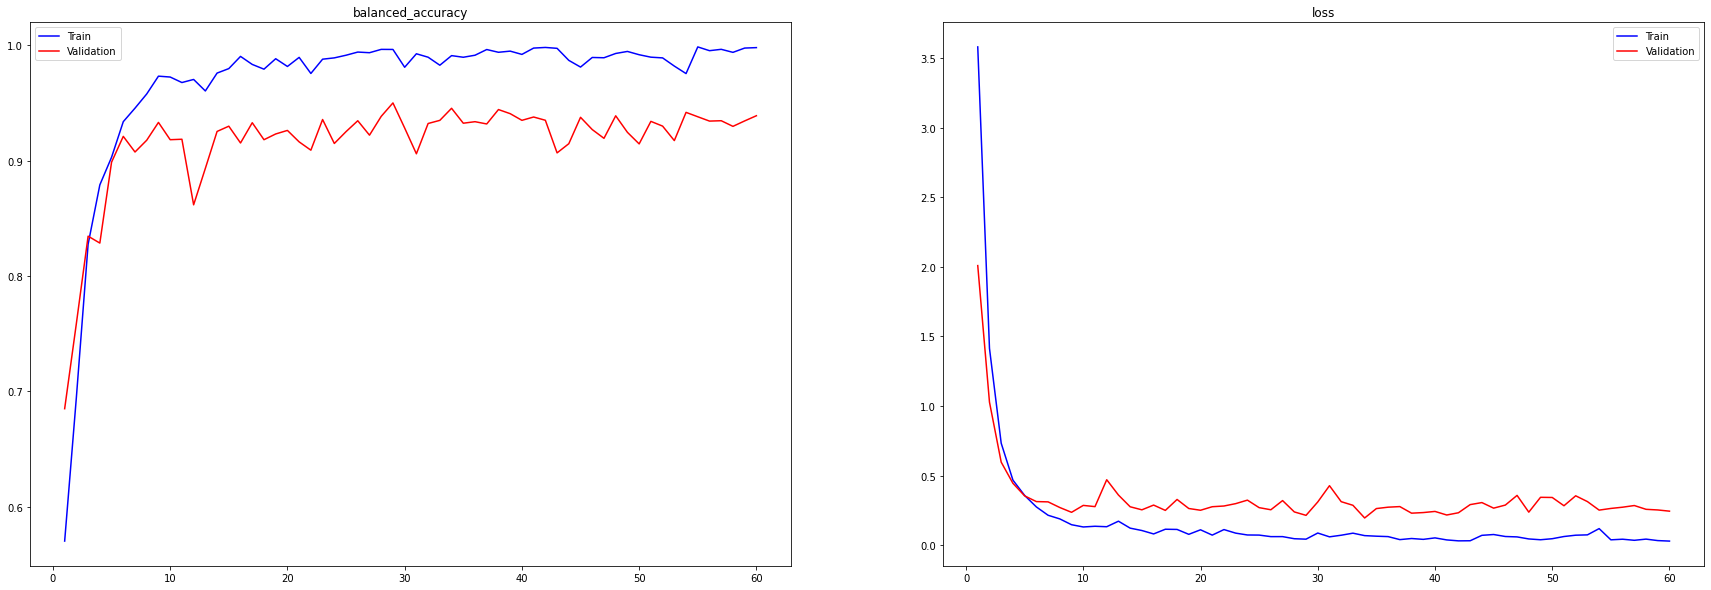

In [47]:
metrics_1, metrics_2 = ['precision_1', 'binary_accuracy', 'recall_1'], ['balanced_accuracy', 'loss']
graph_history(df_le_net_5, metrics_1, epochs=EPOCHS_3)
graph_history(df_le_net_5, metrics_2, epochs=EPOCHS_3)

In [48]:
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_3.csv')

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_3)

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

In [ ]:
metrics_1, metrics_2 = ['precision_1', 'binary_accuracy', 'recall_1'], ['loss', 'balanced_accuracy']
graph_history(df_vgg_16, metrics_1, epochs=EPOCHS_3)
graph_history(df_vgg_16, metrics_2, epochs=EPOCHS_3)

In [ ]:
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_3.csv')

In [10]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_3)

Epoch 1/60
61/61 [==============================] - 1264s 20s/step - loss: 0.8738 - precision: 0.5816 - binary_accuracy: 0.5562 - recall: 0.4041 - balanced_accuracy: 0.5541 - val_loss: 0.8631 - val_precision: 0.6048 - val_binary_accuracy: 0.5691 - val_recall: 0.5020 - val_balanced_accuracy: 0.5724
Epoch 2/60
61/61 [==============================] - 1205s 20s/step - loss: 0.8325 - precision: 0.6159 - binary_accuracy: 0.6032 - recall: 0.5505 - balanced_accuracy: 0.6025 - val_loss: 0.8241 - val_precision: 0.6776 - val_binary_accuracy: 0.6124 - val_recall: 0.4901 - val_balanced_accuracy: 0.6088
Epoch 3/60
61/61 [==============================] - 1174s 19s/step - loss: 0.7940 - precision: 0.7148 - binary_accuracy: 0.6729 - recall: 0.5763 - balanced_accuracy: 0.6731 - val_loss: 0.7997 - val_precision: 0.7396 - val_binary_accuracy: 0.6454 - val_recall: 0.4941 - val_balanced_accuracy: 0.6442
Epoch 4/60
61/61 [==============================] - 1135s 19s/step - loss: 0.7620 - precision: 0.7615 -

KeyboardInterrupt: 

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.693846,0.533040,0.548504,0.864286,0.546086,0.663499,0.571059,0.614433,0.913223,0.627627
1,0.659112,0.540195,0.562436,0.905102,0.557348,0.637073,0.546135,0.577320,0.904959,0.595491
2,0.618711,0.580602,0.618679,0.885714,0.616842,0.607685,0.595870,0.635052,0.834711,0.664313
3,0.592687,0.619048,0.656863,0.835714,0.657238,0.601147,0.584488,0.626804,0.871901,0.655838
4,0.564020,0.670916,0.715686,0.859184,0.714095,0.569618,0.697509,0.729897,0.809917,0.752624


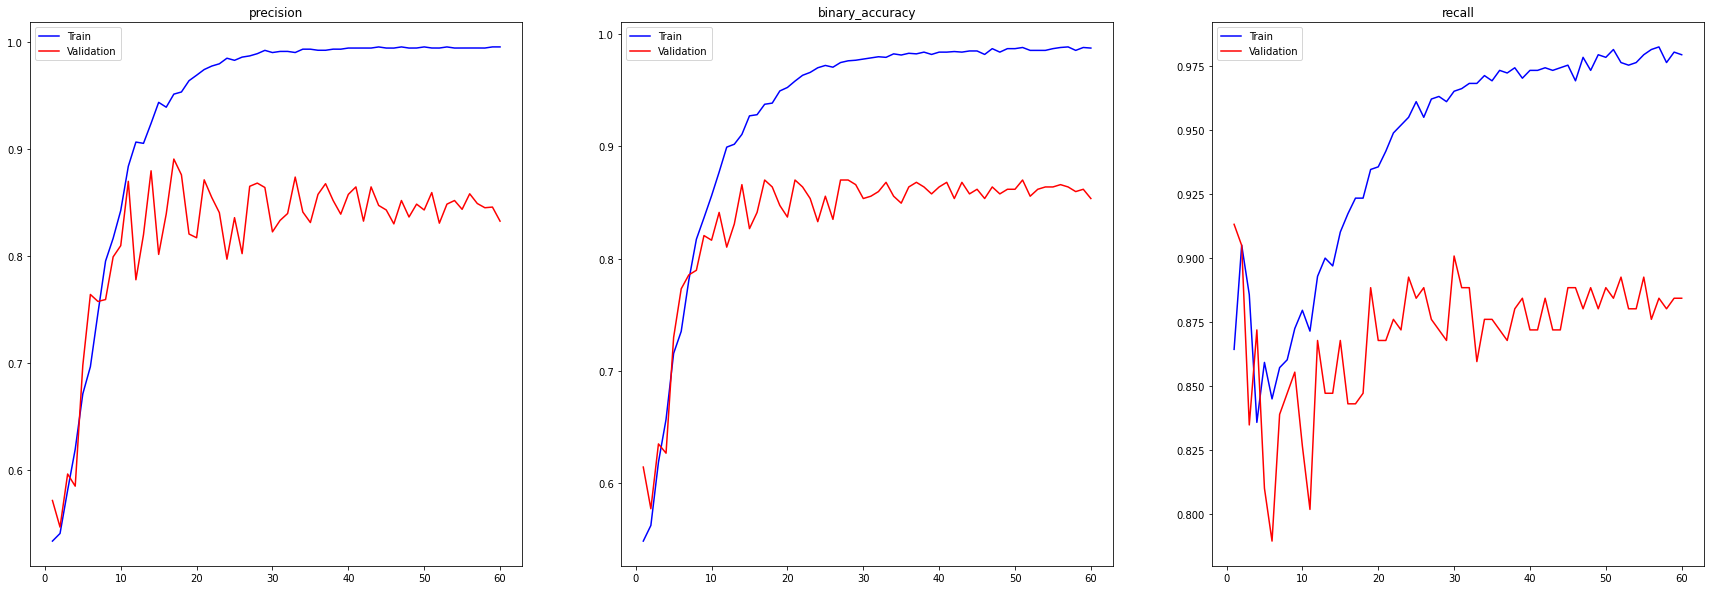

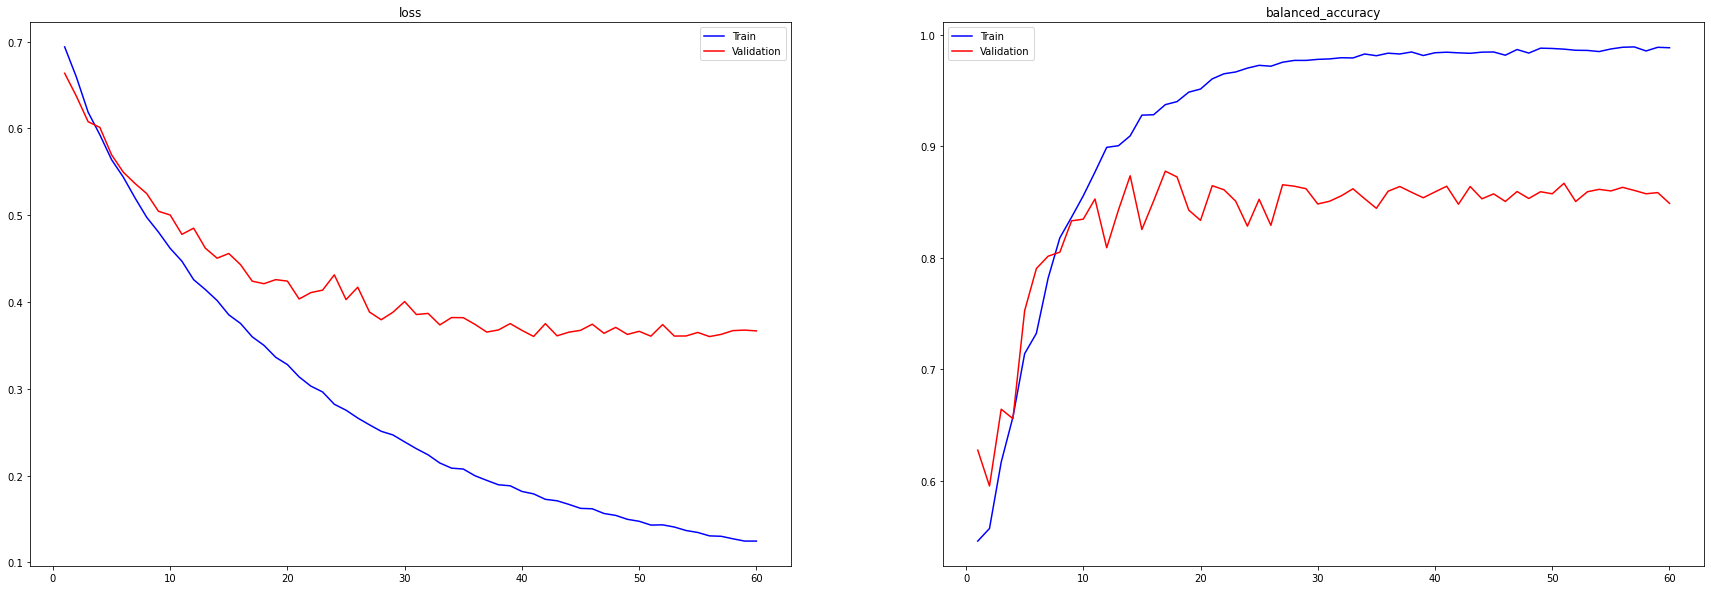

In [ ]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['loss', 'balanced_accuracy']
graph_history(df_lu_net, metrics_1, epochs=EPOCHS_3)
graph_history(df_lu_net, metrics_2, epochs=EPOCHS_3)

In [ ]:
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_3.csv')

NameError: name 'RES_PATH' is not defined

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

In [ ]:
scores_df.to_csv(f'{RES_PATH}/test_scores_3.csv')